<a href="https://colab.research.google.com/github/AndrewCrossman/Graduate_Research/blob/main/BNL_Scripts/BNL_Fit_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install lmfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from google.colab import drive
import csv
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
from scipy.signal import find_peaks
from google.colab import files
import matplotlib.pylab as plt
from lmfit.models import ExponentialModel, GaussianModel, Pearson7Model, LinearModel, SkewedGaussianModel, SplitLorentzianModel, LorentzianModel

This Mounts folders

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!ls '/content/drive/Shareddrives/BNL/BNL_2023'

In [ ]:
directory_path = '/content/drive/Shareddrives/BNL/BNL_2023'

#xrd_files = glob.glob(directory_path + '/*')
#for xmu_file in sort(xmu_files):
#  print(xmu_file)
  #xmu_data = pd.read_csv(xmu_file, on_bad_lines='skip', skiprows=40, names= ['energy', 'xmu', 'bkg', 'pre-edge', 'post-edge', 'der', 'sec', 'i0', 'chi'], sep="\t")
xrd_file='/content/drive/Shareddrives/BNL/BNL_2023/032_xrd_isochronal_20230714-100338_c70924_primary-1_mean_q.chi'
print(xrd_file)
xrd_data = pd.read_csv(xrd_file, on_bad_lines='skip', skiprows=40, names= ['Q', 'chi'], sep="\t")
xrd_data = xrd_data.dropna(axis=1,how='all')
#xrd_data


/content/drive/Shareddrives/BNL/BNL_2023/032_xrd_isochronal_20230714-100338_c70924_primary-1_mean_q.chi


In [ ]:
xrd_data[['Q', 'chi']] = xrd_data[xrd_data.columns[0]].str.split(expand=True).astype(float)
xrd_data

,Q,chi
0,0.136490,9.948960
1,0.139946,10.261844
2,0.143401,10.814281
3,0.146857,11.095107
4,0.150312,11.204466
...,...,...
2956,10.312344,8.603093
2957,10.315761,6.845105
2958,10.319178,6.023423
2959,10.322595,5.982787


This restructures the data array

In [ ]:
plt.plot(xrd_data['Q'],xrd_data['chi'])

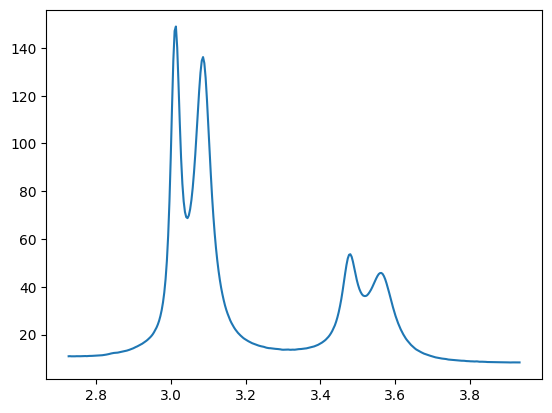

In [ ]:
angles=xrd_data['Q'].to_numpy()
data=xrd_data['chi'].to_numpy()
centerfit=[]
centerfit2=[]
FWHMfit=[]
FWHMfit2=[]
axrange111=np.arange(750,920)  #zoom in on (111) peak
axrange=np.arange(750,1100)  #zoom in on (111) + (200) peak

ang111=angles[axrange111]
ang=angles[axrange]
data=xrd_data['chi']

datazm111=data[axrange111]
datazm=data[axrange]
#print(datazm)
plt.plot(ang,datazm)

In [ ]:
peaks, _ = sp.signal.find_peaks(datazm, height=100)
print(peaks)
print(ang[peaks[0]])
print(ang[peaks[1]])

[ 83 104]
3.01393290522235
3.0864270845802753


(111) fitting only

<Parameter 'p1_center', value=3.0128425102083414 +/- 4.95e-05, bounds=[2.95:3.07]>
<Parameter 'p1_fwhm', value=0.029338092106783363 +/- 0.000172, bounds=[-inf:inf], expr='sqrt(2**(1/p1_expon)-1)*2*p1_sigma'>
<Parameter 'p2_center', value=3.0856326564559056 +/- 7.87e-05, bounds=[3.07:3.15]>
<Parameter 'p2_fwhm', value=0.05412828595951391 +/- 0.000264, bounds=[-inf:inf], expr='sqrt(2**(1/p2_expon)-1)*2*p2_sigma'>


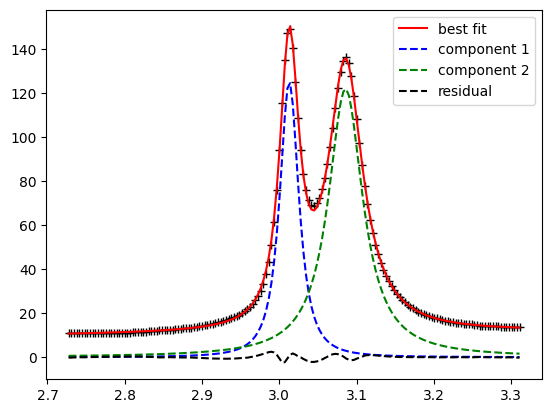

In [ ]:
y=datazm111  #data range to be fit
x=ang111
peaks, _ = sp.signal.find_peaks(y, height=40)
lin_mod = LinearModel(prefix='lin_')
pars = lin_mod.guess(y,x=x)  #linear Background
pearson1 = Pearson7Model(prefix='p1_')  #first peak
pearson2 = Pearson7Model(prefix='p2_')  #second peak
pars.update(pearson1.make_params())
pars.update(pearson2.make_params())
pars['p1_center'].set(3, min=2.95, max=3.07)  #for 111
pars['p1_sigma'].set(.1, min=0)
pars['p1_amplitude'].set(1, min=0)
pars['p1_expon'].set(1, min=.10)

pars['p2_center'].set(3.1, min=3.07, max=3.15)  #for 111
pars['p2_sigma'].set(.1, min=0)
pars['p2_amplitude'].set(1, min=0)
pars['p2_expon'].set(1, min=.10)
mod = pearson1 + pearson2 + lin_mod
init = mod.eval(pars, x=x)

out = mod.fit(y, pars, x=x)
plot_components = True
plt.plot(x, y, 'k+')  #orignal data
#plt.plot(x, init, 'k--') # Initial Guess
plt.plot(x, out.best_fit, 'r-',label='best fit') #best fit
comps = out.eval_components(x=x)
plt.plot(x, comps['p1_'], 'b--', label='component 1')
plt.plot(x, comps['p2_'], 'g--', label='component 2')
plt.plot(x,out.residual,'k--', label='residual')
plt.legend()
print(out.params['p1_center'])
print(out.params['p1_fwhm'])
print(out.params['p2_center'])
print(out.params['p2_fwhm'])



(111)+(200) fitting

<Parameter 'p1_center', value=3.012818042882804 +/- 3.77e-05, bounds=[2.95:3.07]>
<Parameter 'p1_fwhm', value=0.029171378648341278 +/- 0.000129, bounds=[-inf:inf], expr='sqrt(2**(1/p1_expon)-1)*2*p1_sigma'>
<Parameter 'p2_center', value=3.0856042095289684 +/- 5.97e-05, bounds=[3.07:3.15]>
<Parameter 'p2_fwhm', value=0.05453465461899022 +/- 0.000205, bounds=[-inf:inf], expr='sqrt(2**(1/p2_expon)-1)*2*p2_sigma'>
<Parameter 'p3_center', value=3.478446404001347 +/- 0.000188, bounds=[3.4:3.55]>
<Parameter 'p3_fwhm', value=0.05295801478727841 +/- 0.000732, bounds=[-inf:inf], expr='sqrt(2**(1/p3_expon)-1)*2*p3_sigma'>
<Parameter 'p4_center', value=3.562848010354294 +/- 0.000296, bounds=[3.5:3.65]>
<Parameter 'p4_fwhm', value=0.07800227790889833 +/- 0.000917, bounds=[-inf:inf], expr='sqrt(2**(1/p4_expon)-1)*2*p4_sigma'>


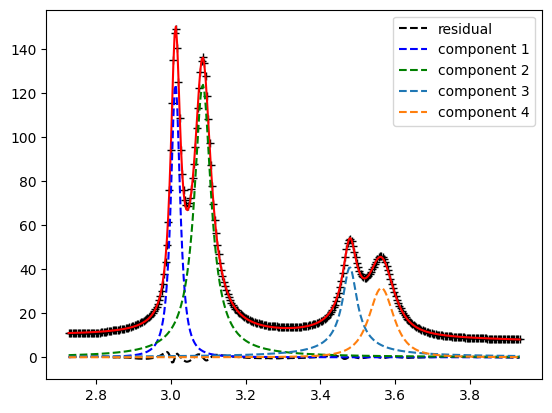

In [ ]:
y=datazm  #data range to be fit
x=ang
lin_mod = LinearModel(prefix='lin_')
pars = lin_mod.guess(y,x=x)  #linear Background
pearson1 = Pearson7Model(prefix='p1_')  #first (111) peak
pearson2 = Pearson7Model(prefix='p2_')  #second (111) peak
pearson3 = Pearson7Model(prefix='p3_')  #first (200) peak
pearson4 = Pearson7Model(prefix='p4_')  #second (200) peak
pars.update(pearson1.make_params())
pars.update(pearson2.make_params())
pars.update(pearson3.make_params())
pars.update(pearson4.make_params())
pars['p1_center'].set(3.013, min=2.95, max=3.07)  #for 111
pars['p1_sigma'].set(.1, min=0)
pars['p1_amplitude'].set(1, min=0)
pars['p1_expon'].set(1, min=.10)

pars['p2_center'].set(3.08, min=3.07, max=3.15)  #for 111
pars['p2_sigma'].set(.1, min=0)
pars['p2_amplitude'].set(1, min=0)
pars['p2_expon'].set(1, min=.10)

pars['p3_center'].set(3.45, min=3.4, max=3.55)  #for 111
pars['p3_sigma'].set(.1, min=0)
pars['p3_amplitude'].set(1, min=0)
pars['p3_expon'].set(1, min=.10)

pars['p4_center'].set(3.55, min=3.5, max=3.65)  #for 111
pars['p4_sigma'].set(.1, min=0)
pars['p4_amplitude'].set(1, min=0)
pars['p4_expon'].set(1, min=.10)
mod = pearson1 + pearson2 + pearson3 + pearson4 + lin_mod
init = mod.eval(pars, x=x)

out = mod.fit(y, pars, x=x)
plot_components = True
plt.plot(x, y, 'k+')  #orignal data
#plt.plot(x, init, 'k--') # Initial Guess
plt.plot(x, out.best_fit, 'r-') #best fit
plt.plot(x,out.residual,'k--',label='residual')

comps = out.eval_components(x=x)
plt.plot(x, comps['p1_'], 'b--', label='component 1')
plt.plot(x, comps['p2_'], 'g--', label='component 2')
plt.plot(x, comps['p3_'], '--', label='component 3')
plt.plot(x, comps['p4_'], '--', label='component 4')
plt.legend()

print(out.params['p1_center'])
print(out.params['p1_fwhm'])
print(out.params['p2_center'])
print(out.params['p2_fwhm'])

print(out.params['p3_center'])
print(out.params['p3_fwhm'])
print(out.params['p4_center'])
print(out.params['p4_fwhm'])